In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import os
import numpy as np
from PIL import Image
from keras.utils import to_categorical

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import pandas as pd
import os, sys
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import splitfolders
import matplotlib.pyplot as plt
from tensorflow.python.keras import regularizers


import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pydot
import glob 
import matplotlib.pyplot as plotter

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')


In [2]:
train_dir = '/FGD/Acadamics and University/Python/Intelligent Systems/Project/rescal224 - split 2/train'
val_dir = '/FGD/Acadamics and University/Python/Intelligent Systems/Project/rescal224 - split 2/val'

In [3]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [4]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [5]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (224, 224, 3), classes = 5):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2, 2))(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model


In [6]:
# Model parameters
img_width, img_height = 224, 224
batch_size = 32
num_classes = 5  # Assuming 5 classes, update if different

# Initialize ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 11397 images belonging to 5 classes.
Found 2851 images belonging to 5 classes.


In [7]:
model = ResNet50(input_shape = (224, 224, 3), classes = 5)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

                                                                                                  
 activation_8 (Activation)      (None, 55, 55, 64)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 55, 55, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 55, 55, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 55, 55, 256)  0           ['activation_6[0][0]',           
                                                                  'batch_normalization_10[0][0]'] 
          

 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 28, 28, 512)  0           ['activation_15[0][0]',          
                                                                  'batch_normalization_20[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 28, 28, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 28, 28, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 28, 28, 128)  512        ['conv2d_21[0][0]']              
 ormalizat

 add_8 (Add)                    (None, 14, 14, 1024  0           ['activation_24[0][0]',          
                                )                                 'batch_normalization_30[0][0]'] 
                                                                                                  
 activation_27 (Activation)     (None, 14, 14, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 14, 14, 256)  262400      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_31 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_31[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_40 (Conv2D)             (None, 14, 14, 256)  262400      ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_40 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 14, 14, 256)  0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 14, 14, 256)  590080      ['activation_37[0][0]']          
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 activation_46 (Activation)     (None, 7, 7, 512)    0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 512)    2359808     ['activation_46[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 512)   2048        ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_47 (Activation)     (None, 7, 7, 512)    0           ['batch_normalization_51[0][0]'] 
          

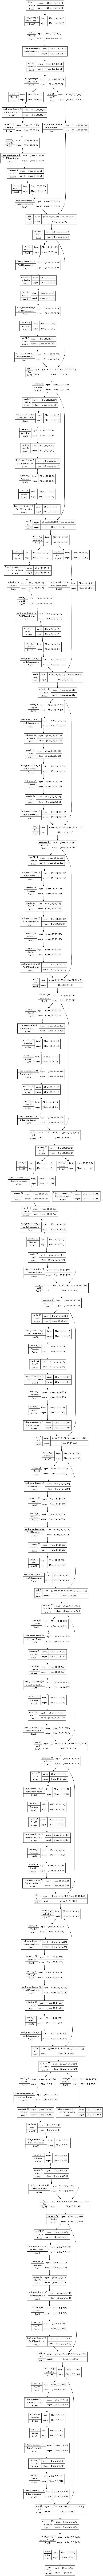

In [8]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Define a checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [11]:

# Fit the model
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint,early_stopping]
)


Epoch 1/15
356/356 [==============================] - 111s 272ms/step - loss: 2.0890 - accuracy: 0.3300 - val_loss: 1.4587 - val_accuracy: 0.3402
Epoch 2/15
356/356 [==============================] - 94s 265ms/step - loss: 1.2366 - accuracy: 0.4773 - val_loss: 1.1528 - val_accuracy: 0.5183
Epoch 3/15
356/356 [==============================] - 94s 265ms/step - loss: 1.0334 - accuracy: 0.5702 - val_loss: 1.0054 - val_accuracy: 0.5888
Epoch 4/15
356/356 [==============================] - 94s 265ms/step - loss: 0.9260 - accuracy: 0.6209 - val_loss: 0.9223 - val_accuracy: 0.6197
Epoch 5/15
356/356 [==============================] - 93s 262ms/step - loss: 0.8158 - accuracy: 0.6670 - val_loss: 0.9238 - val_accuracy: 0.6190
Epoch 6/15
356/356 [==============================] - 94s 264ms/step - loss: 0.7365 - accuracy: 0.6992 - val_loss: 0.8307 - val_accuracy: 0.6492
Epoch 7/15
356/356 [==============================] - 93s 261ms/step - loss: 0.6573 - accuracy: 0.7247 - val_loss: 0.8333 - val_a

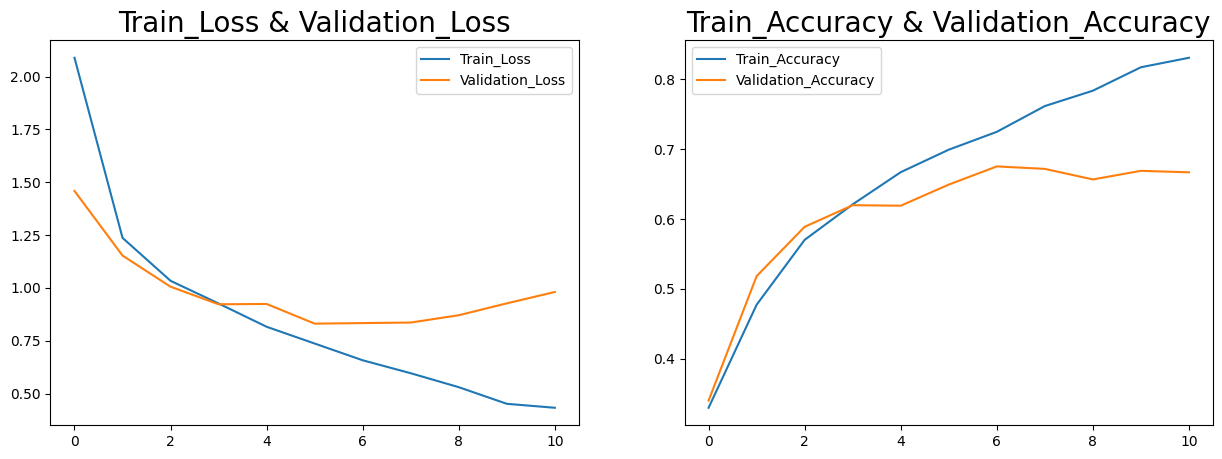

In [12]:
hist_=pd.DataFrame(history.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [13]:
model.save('resnet50.keras')